In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from rlxutils import subplots
import sys
import init
import seaborn as sns
%matplotlib inline

## a continuous joint distribution

from UCI ML repository, [Abalone dataset](https://archive.ics.uci.edu/ml/datasets/Abalone)

In [185]:
x = pd.read_csv("local/data/abalone.data.gz", 
                names=["sex", "length", "diameter", "height", "whole weight", "shucked weight",
                         "viscera weigth", "shell weight", "rings"])
x.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weigth,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


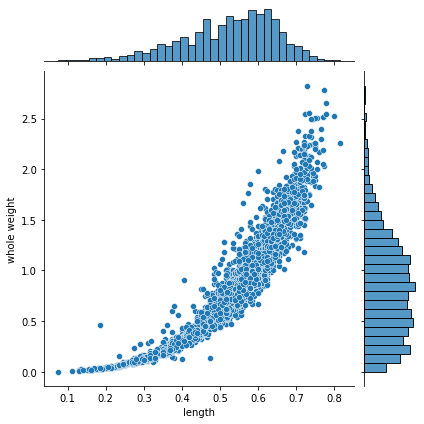

In [32]:
sns.jointplot(data=x, x="length", y="whole weight", kind="scatter")

## probabilities

usually there are two things we want to do when we have a probability distribution, **compute probabilities** and **sampling**

These is an empirical **joint** and **continuous** distributions.

Let's focus on the marginals.  Observe that our dataset is not made of counts (as in previous notebook), but actual values. 

We can compute probabilities, by using the empirical data and counting.

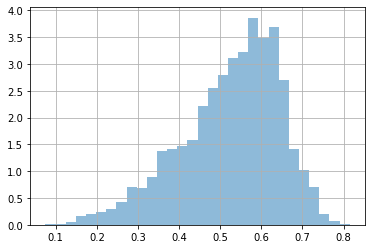

In [61]:
dlen = x['length'].values
plt.hist(dlen, bins=30, density=True, alpha=.5);
plt.grid();

In [42]:
# prob len > 0.5

np.mean(dlen>0.5)

0.6191046205410582

observe that it does not make much sense to ask for a specific value for two reasons:
    
- we are using data to compute probabilities, it is very unlikely that we have data for **any** specific value
- probabilities for a continuous distribution are **infinitesimal**

In [98]:
# observe that it does not make much sense to ask for a specific value
# 
np.sum(dlen==0.6)/len(dlen)

0.02082834570265741

or we can approximate it by estimating a continuous function, with [KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html)

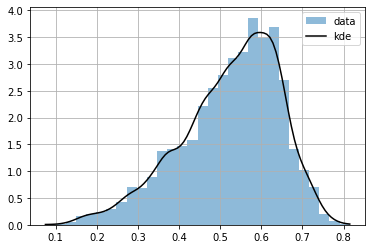

In [79]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(dlen.reshape(-1,1))

# kde provides log probabilities, so we make a utility function 
P = np.vectorize(lambda x: np.exp(kde.score_samples([[x]]))[0])

r = np.linspace(np.min(dlen), np.max(dlen), 100)
plt.hist(dlen, bins=30, density=True, alpha=.5, label="data");
plt.plot(r, P(r), color="black", label="kde")
plt.grid()
plt.legend()

observe that the infinitesimal probability can be >1, but the integration is 1.

In [81]:
from scipy.integrate import quad
quad(P, np.min(dlen), np.max(dlen))[0]

0.9996487658772713

In continuous distributions it only makes sense to ask for **probabilities of intervals**. The CDF is useful for this, but KDE does not provide a CDF.

Let's implement it following

$$CDF(x) = \int_{-\infty}^x P(x)dx$$

In [87]:
# note very efficient but works
CDF = np.vectorize(lambda x: quad(P, np.min(dlen), x)[0])
CDF(.2)

array(0.01128567)

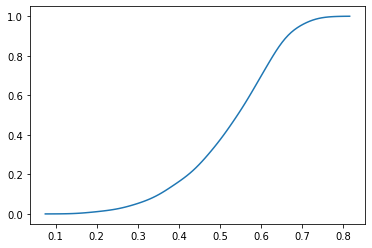

In [88]:
plt.plot(r, CDF(r))

the CDF is useful to compute probabilities of intervals

$$P(x\in(a,b)) = \int_a^b P(x) dx = \int_{-\infty}^b P(x)dx - \int_{-\infty}^a P(x)dx = CDF(b) - CDF(a)$$

In [89]:
a = 0.6
b = 0.7
CDF(0.7) - CDF(0.6)

0.25876642048383736

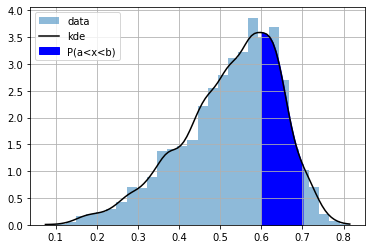

In [97]:
plt.hist(dlen, bins=30, density=True, alpha=.5, label="data");
plt.plot(r, P(r), color="black", label="kde")
plt.grid()

ix = np.linspace(a,b,100)
plt.fill_between(ix, ix*0, P(ix), color="blue", label="P(a<x<b)")
plt.legend();

## sampling

we can use also KDE for sampling new data

In [102]:
s = kde.sample(100000)[:,0]
s

array([0.54076881, 0.39457287, 0.44662223, ..., 0.45683719, 0.63444913,
       0.62494898])

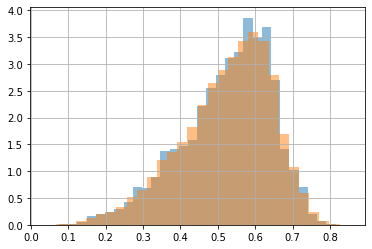

In [105]:
plt.hist(dlen, bins=30, density=True, alpha=.5, label="data");
plt.hist(s, bins=30, density=True, alpha=.5, label="samples");
plt.grid()


## joint distribution (2D)

we can also get a density estimate for the joint distribution

In [118]:
dlen = x['length']
dwei = x['whole weight']

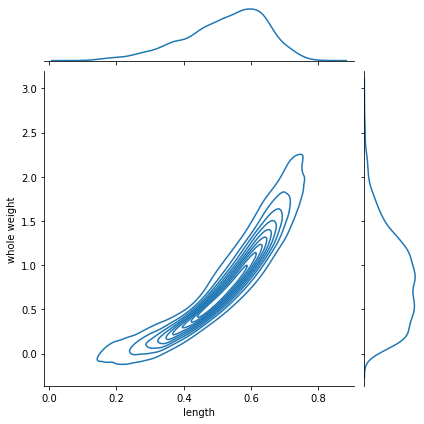

In [120]:
g = sns.jointplot(x=dlen, y=dwei, kind="kde")

In [293]:
kde2d = KernelDensity(bandwidth=.02).fit(x[['length', 'whole weight']].values)

we can compute the pdf at any point (maybe $>1$)

In [208]:
P = lambda x: np.exp(kde2d.score_samples(np.r_[x].reshape(-1,2)))

In [258]:
P([0.6,1])

array([7.36728362])

the PDF must integrate up to 1 in all dimensions

$$\int \int P(l,w)dl dw = 1$$
 
with

- $l$: length
- $w$: weight

but observe the two dimensional numerical integration struggles to compute the value.

In [230]:
from scipy.integrate import dblquad
dblquad(lambda x,y: P([x,y]), np.min(dwei), np.max(dwei), lambda k: np.min(dlen), lambda k: np.max(dlen))

(0.9978512269187759, 1.4695629965797308e-08)

and only integration in a 2d interval givens probabilities $\in [0,1]$

$$P(lw \in \square) = \int_{l_a}^{l_b} \int_{w_a}^{w_b}P(l,w)dldw$$

with $\square$ being the 2D region delimited by $l_a$, $l_b$ and $w_a$, $w_b$

and of course the CDF becomes more complex since we need to accumulate in 2D and becomes almost impractical.

In [266]:
la,lb = 0.5,0.7
wa,wb = 0.9,1.1
pl,pw = 0.6,1.0

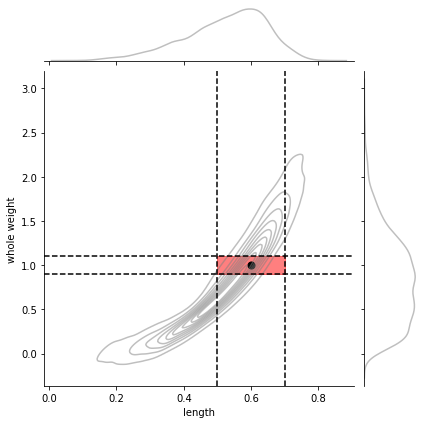

In [272]:
g = sns.jointplot(x=dlen, y=dwei, kind="kde", 
                  joint_kws={"alpha":.5, "color": "gray"},
                  marginal_kws={"alpha":.5, "color": "gray"})
g.ax_joint.fill_between(np.linspace(la,lb,20), [wa]*20, [wb]*20, color="red", alpha=.5)
g.ax_joint.axvline(la, color="black", ls="--")
g.ax_joint.axvline(lb, color="black", ls="--")
g.ax_joint.axhline(wa, color="black", ls="--")
g.ax_joint.axhline(wb, color="black", ls="--")

g.ax_joint.scatter(pl, pw, color="black", s=50);

In [321]:
# the integration of the 2D interval
dblquad(lambda x,y: P([x,y]), wa, wb, lambda k: la, lambda k: lb)[0]

0.13280459408413836

In [270]:
# the PDF value of a point within the interval
P([pl,pw])[0]

7.367283620321121

## marginals from joint

$$P_{len}(l) = \int P(l, w)dw$$
$$P_{weight}(l) = \int P(l, w)dl$$

observe that every time we want to compute a probability from a marginal for one variable we need to integrate (sum up) across the other variable. This is computationally expensive, even for this small case.

These marginals match the ones as plotted above.

In [240]:
P_len = np.vectorize(lambda x: quad(lambda y: P([x,y]), np.min(dwei), np.max(dwei))[0])
# check marginal integraetes to 1
quad(P_len, np.min(dlen), np.max(dlen))[0]


0.997851226911095

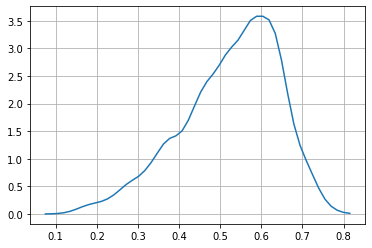

In [287]:
rlen = np.linspace(np.min(dlen), np.max(dlen), 50)
plt.plot(rlen, P_len(rlen))                     
plt.grid();

observe the numerical instabilities

In [242]:
P_wei = np.vectorize(lambda y: quad(lambda x: P([x,y]), np.min(dlen), np.max(dlen))[0])
# check marginal integraetes to 1
quad(P_wei, np.min(dwei), np.max(dwei))[0]

0.9978512269187759

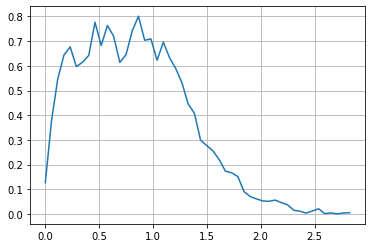

In [296]:
rwei = np.linspace(np.min(dwei), np.max(dwei), 50)
plt.plot(rwei, P_wei(rwei))                     
plt.grid();

## conditionals from joint

a conditional is just a slice for the conditioned value, normalized so that we have a proper probability distribution

$$P(l|w) = \frac{P(l,w)}{\int P(l,w)dw}$$

for instance $P(l|w=1)$ looks as follows

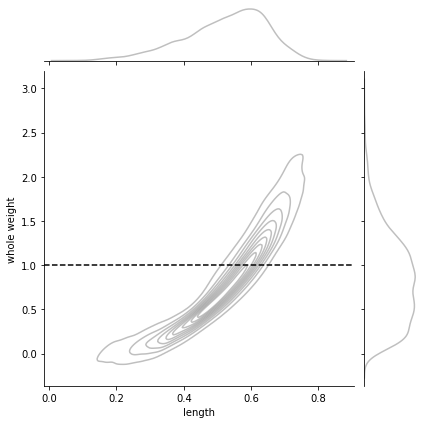

In [299]:
w = 1
g = sns.jointplot(x=dlen, y=dwei, kind="kde", 
                  joint_kws={"alpha":.5, "color": "gray"},
                  marginal_kws={"alpha":.5, "color": "gray"})
g.ax_joint.axhline(w, color="black", ls="--", label="w")

In [300]:
Pu = lambda x: P([x,w]) # unnormalized conditional
Z = quad(Pu, np.min(dlen), np.max(dlen))[0]
Pc = np.vectorize(lambda x: Pu(x)/Z)   # normalized conditional

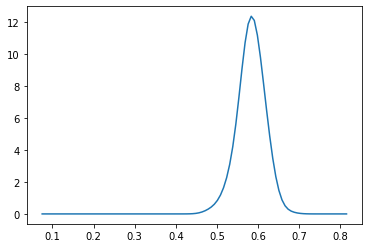

In [301]:
r = np.linspace(np.min(dlen), np.max(dlen), 100)
plt.plot(r, Pc(r))

## sampling

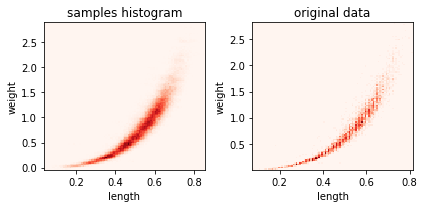

In [318]:
for ax,i in subplots(2):
    s = kde2d.sample(100000)
    
    if i==0: 
        plt.hist2d(s[:,0], s[:,1], bins=100, label="samples", cmap=plt.cm.Reds);
        plt.title("samples histogram")
    if i==1: 
        plt.hist2d(dlen, dwei, bins=100, label="samples", cmap=plt.cm.Reds);
        plt.title("original data")

    plt.xlabel("length")
    plt.ylabel("weight")
plt.tight_layout()


In [307]:
s

array([[0.51530533, 0.6138152 ],
       [0.63590029, 1.1842212 ],
       [0.57986584, 0.7704644 ],
       ...,
       [0.42625826, 0.25589309],
       [0.52939054, 0.57865795],
       [0.49685327, 0.7903932 ]])

In [320]:
len(s), len(dlen)

(100000, 4177)